# Naive Bayes BaselineThis notebook combines the pure-Python Naive Bayes implementation with the commentary from `NAIVE_BAYES_NOTES.md`.Run the cell below to train/test the model using the offline UCI dataset (`data/online_shoppers_intention.csv`).

In [63]:
import csv
import math
import random
from pathlib import Path
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

print("✓ Successfully imported all required libraries")
print("  - csv, math, random, pathlib, typing, matplotlib")

✓ Successfully imported all required libraries
  - csv, math, random, pathlib, typing, matplotlib


**Import necessary libraries for file handling, mathematical operations, randomization, and type hints.**

In [64]:
CATEGORY_COLUMNS = {
    "Month",
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "VisitorType",
    "Weekend",
}

TARGET_COL = "Revenue"

print("✓ Defined feature types:")
print(f"  - Categorical columns ({len(CATEGORY_COLUMNS)}): {', '.join(sorted(CATEGORY_COLUMNS))}")
print(f"  - Target column: {TARGET_COL}")

✓ Defined feature types:
  - Categorical columns (7): Browser, Month, OperatingSystems, Region, TrafficType, VisitorType, Weekend
  - Target column: Revenue


**Define which columns are categorical vs numerical, and specify the target column (Revenue).**

In [65]:
def load_dataset(csv_path: Path) -> Tuple[List[List[float]], List[int], List[str]]:
    """Load dataset from CSV and separate features from labels."""
    print(f"\n{'='*60}")
    print(f"LOADING DATASET FROM: {csv_path}")
    print(f"{'='*60}")
    
    with csv_path.open(newline="") as f:
        reader = csv.DictReader(f)
        columns = [c for c in reader.fieldnames if c != TARGET_COL]
        records, labels = [], []
        
        for row in reader:
            features: List = []
            for col in columns:
                val = row[col]
                if col in CATEGORY_COLUMNS:
                    features.append(val.strip())
                else:
                    features.append(float(val))
            
            label = 1 if row[TARGET_COL].strip().lower() == "true" else 0
            records.append(features)
            labels.append(label)
    
    num_positive = sum(labels)
    num_negative = len(labels) - num_positive
    
    print(f"✓ Dataset loaded successfully!")
    print(f"  - Total samples: {len(records)}")
    print(f"  - Total features: {len(columns)}")
    print(f"  - Numerical features: {len([c for c in columns if c not in CATEGORY_COLUMNS])}")
    print(f"  - Categorical features: {len([c for c in columns if c in CATEGORY_COLUMNS])}")
    print(f"  - Class distribution:")
    print(f"    • Positive (Revenue=True): {num_positive} ({num_positive/len(labels)*100:.2f}%)")
    print(f"    • Negative (Revenue=False): {num_negative} ({num_negative/len(labels)*100:.2f}%)")
    
    return records, labels, columns

**Load the dataset from CSV file. Categorical features are kept as strings, numerical features are converted to floats. The target column (Revenue) is converted to binary (1 for True, 0 for False).**

In [66]:
def stratified_split(
    data: List[List], labels: List[int], test_ratio: float = 0.2
) -> Tuple[List[List], List[int], List[List], List[int]]:
    """Split data into train/test sets while maintaining class distribution."""
    print(f"\n{'='*60}")
    print(f"PERFORMING STRATIFIED TRAIN/TEST SPLIT")
    print(f"{'='*60}")
    
    grouped = {0: [], 1: []}
    for feat, lab in zip(data, labels):
        grouped[lab].append((feat, lab))
    
    print(f"Class distribution before split:")
    print(f"  - Class 0 (Negative): {len(grouped[0])} samples")
    print(f"  - Class 1 (Positive): {len(grouped[1])} samples")
    
    for group in grouped.values():
        random.shuffle(group)
    
    train_X, train_y, test_X, test_y = [], [], [], []
    for cls, items in grouped.items():
        split = int(len(items) * (1 - test_ratio))
        for feat, lab in items[:split]:
            train_X.append(feat)
            train_y.append(lab)
        for feat, lab in items[split:]:
            test_X.append(feat)
            test_y.append(lab)
    
    print(f"\n✓ Split complete!")
    print(f"  - Train set: {len(train_X)} samples ({(1-test_ratio)*100:.0f}%)")
    print(f"    • Class 0: {train_y.count(0)} samples")
    print(f"    • Class 1: {train_y.count(1)} samples")
    print(f"  - Test set: {len(test_X)} samples ({test_ratio*100:.0f}%)")
    print(f"    • Class 0: {test_y.count(0)} samples")
    print(f"    • Class 1: {test_y.count(1)} samples")
    
    return train_X, train_y, test_X, test_y

**Perform stratified train/test split to maintain the same class distribution in both sets. Default is 80/20 split.**

In [67]:
class NaiveBayes:
    """Naive Bayes classifier for mixed numerical and categorical features."""
    
    def __init__(self, numeric_idx: List[int], categorical_idx: List[int]):
        """Initialize with indices of numeric and categorical columns."""
        self.numeric_idx = numeric_idx
        self.categorical_idx = categorical_idx
        self.priors: Dict[int, float] = {}
        self.num_stats: Dict[int, Dict[int, Tuple[float, float]]] = {}
        self.cat_counts: Dict[int, Dict[int, Dict[str, int]]] = {}
        self.cat_totals: Dict[int, Dict[int, int]] = {}
        
        print(f"\n{'='*60}")
        print(f"INITIALIZING NAIVE BAYES CLASSIFIER")
        print(f"{'='*60}")
        print(f"  - Numerical features: {len(numeric_idx)}")
        print(f"  - Categorical features: {len(categorical_idx)}")
    
    def fit(self, X: List[List], y: List[int]):
        """Train the Naive Bayes model on the training data."""
        print(f"\n{'='*60}")
        print(f"TRAINING NAIVE BAYES MODEL")
        print(f"{'='*60}")
        
        n = len(y)
        class_indices: Dict[int, List[int]] = {0: [], 1: []}
        for idx, label in enumerate(y):
            class_indices[label].append(idx)
        
        for cls, indices in class_indices.items():
            # Calculate prior probability for each class
            self.priors[cls] = len(indices) / n
            print(f"\nClass {cls}:")
            print(f"  - Prior probability: {self.priors[cls]:.4f}")
            print(f"  - Number of samples: {len(indices)}")
            
            # Calculate mean and variance for numerical features
            self.num_stats[cls] = {}
            for col in self.numeric_idx:
                values = [X[i][col] for i in indices]
                mean = sum(values) / len(values)
                var = sum((v - mean) ** 2 for v in values) / max(len(values) - 1, 1)
                self.num_stats[cls][col] = (mean, var if var > 1e-6 else 1e-6)
            
            print(f"  - Calculated statistics for {len(self.numeric_idx)} numerical features")
            
            # Count categorical feature values
            self.cat_counts.setdefault(cls, {})
            self.cat_totals.setdefault(cls, {})
            total_categories = 0
            for col in self.categorical_idx:
                counts: Dict[str, int] = {}
                for i in indices:
                    key = X[i][col]
                    counts[key] = counts.get(key, 0) + 1
                self.cat_counts[cls][col] = counts
                self.cat_totals[cls][col] = sum(counts.values())
                total_categories += len(counts)
            
            print(f"  - Counted {total_categories} unique categorical values across {len(self.categorical_idx)} features")
        
        print(f"\n✓ Model training complete!")
    
    def _gaussian_log_prob(self, value: float, mean: float, var: float) -> float:
        """Calculate log probability for a Gaussian distribution."""
        return -0.5 * (
            math.log(2 * math.pi * var) + ((value - mean) ** 2) / var
        )
    
    def predict_row(self, row: List) -> int:
        """Predict the class label for a single row."""
        log_posteriors = {}
        for cls in self.priors:
            log_prob = math.log(self.priors[cls])
            
            # Add log probabilities for numerical features
            for col in self.numeric_idx:
                mean, var = self.num_stats[cls][col]
                log_prob += self._gaussian_log_prob(row[col], mean, var)
            
            # Add log probabilities for categorical features
            for col in self.categorical_idx:
                counts = self.cat_counts[cls][col]
                total = self.cat_totals[cls][col]
                value = row[col]
                count = counts.get(value, 0)
                smoothing = 1.0
                vocab_size = len(counts)
                log_prob += math.log((count + smoothing) / (total + smoothing * vocab_size))
            
            log_posteriors[cls] = log_prob
        
        return max(log_posteriors, key=log_posteriors.get)
    
    def predict(self, X: List[List]) -> List[int]:
        """Predict class labels for multiple rows."""
        print(f"\n{'='*60}")
        print(f"MAKING PREDICTIONS")
        print(f"{'='*60}")
        print(f"  - Number of samples to predict: {len(X)}")
        
        predictions = [self.predict_row(row) for row in X]
        
        num_positive = sum(predictions)
        num_negative = len(predictions) - num_positive
        
        print(f"  - Predicted class distribution:")
        print(f"    • Class 0 (Negative): {num_negative} ({num_negative/len(predictions)*100:.2f}%)")
        print(f"    • Class 1 (Positive): {num_positive} ({num_positive/len(predictions)*100:.2f}%)")
        print(f"✓ Predictions complete!")
        
        return predictions

**Complete Naive Bayes classifier implementation including:**
- **Initialization**: Set up feature indices and storage for statistics
- **Training (fit)**: Calculate prior probabilities, mean/variance for numerical features, frequency counts for categorical features
- **Prediction**: Use Gaussian log probability for numerical features and Laplace smoothing for categorical features to predict class labels

# Model Execution & Analysis

This section executes the Naive Bayes model step-by-step, allowing you to observe and analyze each stage of the machine learning pipeline.

## 1. Setup & Configuration

In [68]:
# Set random seed for reproducibility
random.seed(441)
print("="*60)
print(" "*15 + "NAIVE BAYES BASELINE")
print("="*60)
print("✓ Random seed set to 441 for reproducibility")

               NAIVE BAYES BASELINE
✓ Random seed set to 441 for reproducibility


## 2. Data Loading

In [69]:
# Load dataset from Downloads folder
data_path = Path.home() / "Downloads" / "online_shoppers_intention 2.csv"
X, y, columns = load_dataset(data_path)


LOADING DATASET FROM: /Users/zhuqiang/Downloads/online_shoppers_intention 2.csv
✓ Dataset loaded successfully!
  - Total samples: 12330
  - Total features: 17
  - Numerical features: 10
  - Categorical features: 7
  - Class distribution:
    • Positive (Revenue=True): 1908 (15.47%)
    • Negative (Revenue=False): 10422 (84.53%)


## 3. Feature Type Identification

In [70]:
# Identify numeric and categorical column indices
numeric_idx = [
    idx
    for idx, name in enumerate(columns)
    if name not in CATEGORY_COLUMNS
]
categorical_idx = [
    idx
    for idx, name in enumerate(columns)
    if name in CATEGORY_COLUMNS
]

print(f"\n{'='*60}")
print(f"FEATURE TYPE SEPARATION")
print(f"{'='*60}")
print(f"  - Numerical feature indices: {numeric_idx}")
print(f"  - Categorical feature indices: {categorical_idx}")
print(f"\n  - Numerical feature names: {[columns[i] for i in numeric_idx]}")
print(f"  - Categorical feature names: {[columns[i] for i in categorical_idx]}")


FEATURE TYPE SEPARATION
  - Numerical feature indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  - Categorical feature indices: [10, 11, 12, 13, 14, 15, 16]

  - Numerical feature names: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
  - Categorical feature names: ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']


## 4. Train/Test Split

In [71]:
# Split data into train and test sets (80/20 split)
X_train, y_train, X_test, y_test = stratified_split(X, y, test_ratio=0.2)


PERFORMING STRATIFIED TRAIN/TEST SPLIT
Class distribution before split:
  - Class 0 (Negative): 10422 samples
  - Class 1 (Positive): 1908 samples

✓ Split complete!
  - Train set: 9863 samples (80%)
    • Class 0: 8337 samples
    • Class 1: 1526 samples
  - Test set: 2467 samples (20%)
    • Class 0: 2085 samples
    • Class 1: 382 samples


## 5. Model Training

In [72]:
# Initialize and train the Naive Bayes model
nb = NaiveBayes(numeric_idx=numeric_idx, categorical_idx=categorical_idx)
nb.fit(X_train, y_train)


INITIALIZING NAIVE BAYES CLASSIFIER
  - Numerical features: 10
  - Categorical features: 7

TRAINING NAIVE BAYES MODEL

Class 0:
  - Prior probability: 0.8453
  - Number of samples: 8337
  - Calculated statistics for 10 numerical features
  - Counted 64 unique categorical values across 7 features

Class 1:
  - Prior probability: 0.1547
  - Number of samples: 1526
  - Calculated statistics for 10 numerical features
  - Counted 59 unique categorical values across 7 features

✓ Model training complete!


## 6. Predictions

In [73]:
# Make predictions on the test set
preds = nb.predict(X_test)


MAKING PREDICTIONS
  - Number of samples to predict: 2467
  - Predicted class distribution:
    • Class 0 (Negative): 1890 (76.61%)
    • Class 1 (Positive): 577 (23.39%)
✓ Predictions complete!


## 7. Model Evaluation

In [74]:
# Calculate performance metrics
accuracy = sum(p == t for p, t in zip(preds, y_test)) / len(y_test)

# Calculate confusion matrix elements
true_positive = sum(1 for p, t in zip(preds, y_test) if p == 1 and t == 1)
true_negative = sum(1 for p, t in zip(preds, y_test) if p == 0 and t == 0)
false_positive = sum(1 for p, t in zip(preds, y_test) if p == 1 and t == 0)
false_negative = sum(1 for p, t in zip(preds, y_test) if p == 0 and t == 1)

# Calculate additional metrics
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"{'='*60}")
print(f"MODEL EVALUATION RESULTS")
print(f"{'='*60}")
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                  Neg    Pos")
print(f"  Actual  Neg   [{true_negative:5d}  {false_positive:5d}]")
print(f"          Pos   [{false_negative:5d}  {true_positive:5d}]")
print(f"\nPerformance Metrics:")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1 Score:  {f1_score:.4f} ({f1_score*100:.2f}%)")

MODEL EVALUATION RESULTS

Confusion Matrix:
                  Predicted
                  Neg    Pos
  Actual  Neg   [ 1758    327]
          Pos   [  132    250]

Performance Metrics:
  - Accuracy:  0.8139 (81.39%)
  - Precision: 0.4333 (43.33%)
  - Recall:    0.6545 (65.45%)
  - F1 Score:  0.5214 (52.14%)


### Confusion Matrix Visualization

In [75]:
# Create a visual representation of the confusion matrix
print("\nConfusion Matrix Heatmap (text-based):")
print("="*60)

# Calculate percentages
total = true_negative + true_positive + false_negative + false_positive
tn_pct = (true_negative / total) * 100
tp_pct = (true_positive / total) * 100
fn_pct = (false_negative / total) * 100
fp_pct = (false_positive / total) * 100

# Create visual bars
def make_bar(value, max_val=total):
    bar_length = int((value / max_val) * 40)
    return "█" * bar_length

print(f"\nTrue Negatives:  {true_negative:5d} ({tn_pct:5.2f}%) {make_bar(true_negative)}")
print(f"True Positives:  {true_positive:5d} ({tp_pct:5.2f}%) {make_bar(true_positive)}")
print(f"False Negatives: {false_negative:5d} ({fn_pct:5.2f}%) {make_bar(false_negative)}")
print(f"False Positives: {false_positive:5d} ({fp_pct:5.2f}%) {make_bar(false_positive)}")

print(f"\nCorrect Predictions: {true_negative + true_positive} / {total} = {((true_negative + true_positive)/total)*100:.2f}%")
print(f"Incorrect Predictions: {false_negative + false_positive} / {total} = {((false_negative + false_positive)/total)*100:.2f}%")


Confusion Matrix Heatmap (text-based):

True Negatives:   1758 (71.26%) ████████████████████████████
True Positives:    250 (10.13%) ████
False Negatives:   132 ( 5.35%) ██
False Positives:   327 (13.25%) █████

Correct Predictions: 2008 / 2467 = 81.39%
Incorrect Predictions: 459 / 2467 = 18.61%


## 8. Model Comparison

In [76]:
# Compare with other baseline models
comparison = {
    "Logistic Regression": 0.8731,
    "Neural Network": 0.8881,
    "Random Forest (tuned)": 0.8946,
    "XGBoost (tuned)": 0.8994,
    "Naive Bayes": round(accuracy, 4),
}

print(f"\n{'='*60}")
print(f"MODEL COMPARISON (Test Set Accuracy)")
print(f"{'='*60}\n")

# Sort by accuracy
sorted_models = sorted(comparison.items(), key=lambda x: x[1], reverse=True)

for rank, (name, score) in enumerate(sorted_models, 1):
    bar = "█" * int(score * 50)
    marker = " ← YOUR MODEL" if name == "Naive Bayes" else ""
    print(f"{rank}. {name:<25} {score:.4f} ({score*100:.2f}%) {bar}{marker}")

# Calculate performance gap
best_model = sorted_models[0][0]
best_score = sorted_models[0][1]
nb_score = comparison["Naive Bayes"]

print(f"\n{'='*60}")
print(f"PERFORMANCE ANALYSIS")
print(f"{'='*60}")
print(f"  - Best performing model: {best_model} ({best_score:.4f})")
print(f"  - Naive Bayes score: {nb_score:.4f}")
print(f"  - Performance gap: {abs(best_score - nb_score):.4f} ({abs(best_score - nb_score)*100:.2f}%)")
print(f"\n  Note: Naive Bayes provides a lightweight, interpretable baseline")
print(f"  with reasonable performance despite using simple probabilistic assumptions.")


MODEL COMPARISON (Test Set Accuracy)

1. XGBoost (tuned)           0.8994 (89.94%) ████████████████████████████████████████████
2. Random Forest (tuned)     0.8946 (89.46%) ████████████████████████████████████████████
3. Neural Network            0.8881 (88.81%) ████████████████████████████████████████████
4. Logistic Regression       0.8731 (87.31%) ███████████████████████████████████████████
5. Naive Bayes               0.8139 (81.39%) ████████████████████████████████████████ ← YOUR MODEL

PERFORMANCE ANALYSIS
  - Best performing model: XGBoost (tuned) (0.8994)
  - Naive Bayes score: 0.8139
  - Performance gap: 0.0855 (8.55%)

  Note: Naive Bayes provides a lightweight, interpretable baseline
  with reasonable performance despite using simple probabilistic assumptions.


## 9. Summary & Key Takeaways

In [77]:
print("\n" + "="*60)
print(" "*20 + "SUMMARY REPORT")
print("="*60)

print("\n📊 Dataset:")
print(f"   - Total samples: {len(X)}")
print(f"   - Train samples: {len(X_train)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Features: {len(columns)} ({len(numeric_idx)} numerical, {len(categorical_idx)} categorical)")

print("\n🎯 Model Performance:")
print(f"   - Accuracy:  {accuracy:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall:    {recall:.4f}")
print(f"   - F1 Score:  {f1_score:.4f}")

print("\n🔍 Key Insights:")
print(f"   - The model correctly classified {true_negative + true_positive} out of {total} samples")
print(f"   - True Positive Rate (Sensitivity): {recall:.2%}")
print(f"   - True Negative Rate (Specificity): {true_negative/(true_negative+false_positive):.2%}")
print(f"   - Positive Predictive Value: {precision:.2%}")

print("\n✅ Strengths:")
print("   - Pure Python implementation (no external ML libraries)")
print("   - Handles mixed numerical and categorical features")
print("   - Fast training and prediction")
print("   - Interpretable probabilistic model")

print("\n⚠️  Limitations:")
print("   - Assumes feature independence (often violated in real data)")
print("   - Gaussian assumption for numerical features may not always hold")
print(f"   - Performance gap of {abs(best_score - nb_score)*100:.2f}% compared to best model")

print("\n" + "="*60)
print("✓ Analysis Complete!")
print("="*60 + "\n")


                    SUMMARY REPORT

📊 Dataset:
   - Total samples: 12330
   - Train samples: 9863
   - Test samples: 2467
   - Features: 17 (10 numerical, 7 categorical)

🎯 Model Performance:
   - Accuracy:  0.8139
   - Precision: 0.4333
   - Recall:    0.6545
   - F1 Score:  0.5214

🔍 Key Insights:
   - The model correctly classified 2008 out of 2467 samples
   - True Positive Rate (Sensitivity): 65.45%
   - True Negative Rate (Specificity): 84.32%
   - Positive Predictive Value: 43.33%

✅ Strengths:
   - Pure Python implementation (no external ML libraries)
   - Handles mixed numerical and categorical features
   - Fast training and prediction
   - Interpretable probabilistic model

⚠️  Limitations:
   - Assumes feature independence (often violated in real data)
   - Gaussian assumption for numerical features may not always hold
   - Performance gap of 8.55% compared to best model

✓ Analysis Complete!



# Parameter Tuning & Optimization

Let's experiment with different parameters to improve the model's accuracy beyond 80%.

## 10. Enhanced Naive Bayes with Tunable Parameters

In [78]:
class NaiveBayesTuned:
    """Enhanced Naive Bayes classifier with tunable parameters."""
    
    def __init__(self, numeric_idx: List[int], categorical_idx: List[int], 
                 smoothing: float = 1.0, min_variance: float = 1e-6):
        """
        Initialize with tunable parameters.
        
        Parameters:
        - smoothing: Laplace smoothing parameter for categorical features (default: 1.0)
        - min_variance: Minimum variance threshold for numerical features (default: 1e-6)
        """
        self.numeric_idx = numeric_idx
        self.categorical_idx = categorical_idx
        self.smoothing = smoothing  # Tunable parameter
        self.min_variance = min_variance  # Tunable parameter
        self.priors: Dict[int, float] = {}
        self.num_stats: Dict[int, Dict[int, Tuple[float, float]]] = {}
        self.cat_counts: Dict[int, Dict[int, Dict[str, int]]] = {}
        self.cat_totals: Dict[int, Dict[int, int]] = {}
    
    def fit(self, X: List[List], y: List[int]):
        """Train the Naive Bayes model on the training data."""
        n = len(y)
        class_indices: Dict[int, List[int]] = {0: [], 1: []}
        for idx, label in enumerate(y):
            class_indices[label].append(idx)
        
        for cls, indices in class_indices.items():
            # Calculate prior probability for each class
            self.priors[cls] = len(indices) / n
            
            # Calculate mean and variance for numerical features
            self.num_stats[cls] = {}
            for col in self.numeric_idx:
                values = [X[i][col] for i in indices]
                mean = sum(values) / len(values)
                var = sum((v - mean) ** 2 for v in values) / max(len(values) - 1, 1)
                self.num_stats[cls][col] = (mean, max(var, self.min_variance))
            
            # Count categorical feature values
            self.cat_counts.setdefault(cls, {})
            self.cat_totals.setdefault(cls, {})
            for col in self.categorical_idx:
                counts: Dict[str, int] = {}
                for i in indices:
                    key = X[i][col]
                    counts[key] = counts.get(key, 0) + 1
                self.cat_counts[cls][col] = counts
                self.cat_totals[cls][col] = sum(counts.values())
    
    def _gaussian_log_prob(self, value: float, mean: float, var: float) -> float:
        """Calculate log probability for a Gaussian distribution."""
        return -0.5 * (
            math.log(2 * math.pi * var) + ((value - mean) ** 2) / var
        )
    
    def predict_proba_row(self, row: List) -> Tuple[float, float]:
        """Predict probability scores for a single row."""
        log_posteriors = {}
        for cls in self.priors:
            log_prob = math.log(self.priors[cls])
            
            # Add log probabilities for numerical features
            for col in self.numeric_idx:
                mean, var = self.num_stats[cls][col]
                log_prob += self._gaussian_log_prob(row[col], mean, var)
            
            # Add log probabilities for categorical features with smoothing
            for col in self.categorical_idx:
                counts = self.cat_counts[cls][col]
                total = self.cat_totals[cls][col]
                value = row[col]
                count = counts.get(value, 0)
                vocab_size = len(counts)
                log_prob += math.log((count + self.smoothing) / (total + self.smoothing * vocab_size))
            
            log_posteriors[cls] = log_prob
        
        # Convert log probabilities to probabilities using exp and normalize
        max_log_prob = max(log_posteriors.values())
        probs = {cls: math.exp(log_prob - max_log_prob) for cls, log_prob in log_posteriors.items()}
        total_prob = sum(probs.values())
        normalized_probs = {cls: p / total_prob for cls, p in probs.items()}
        
        # Return probability for class 0 and class 1
        return normalized_probs.get(0, 0.0), normalized_probs.get(1, 0.0)
    
    def predict_row(self, row: List) -> int:
        """Predict the class label for a single row."""
        prob_0, prob_1 = self.predict_proba_row(row)
        return 1 if prob_1 > prob_0 else 0
    
    def predict(self, X: List[List]) -> List[int]:
        """Predict class labels for multiple rows."""
        return [self.predict_row(row) for row in X]
    
    def predict_proba(self, X: List[List]) -> List[Tuple[float, float]]:
        """Predict probability scores for multiple rows."""
        return [self.predict_proba_row(row) for row in X]

print("✓ Enhanced NaiveBayesTuned class defined")
print(f"  - Tunable parameters: smoothing, min_variance")
print(f"  - Added predict_proba() method for ROC curves")

✓ Enhanced NaiveBayesTuned class defined
  - Tunable parameters: smoothing, min_variance
  - Added predict_proba() method for ROC curves


## 11. Grid Search for Optimal Parameters

In [79]:
# Define parameter grid to search
smoothing_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
variance_values = [1e-9, 1e-6, 1e-3, 1e-1]

print("="*60)
print("PARAMETER GRID SEARCH")
print("="*60)
print(f"\nTesting {len(smoothing_values)} smoothing values: {smoothing_values}")
print(f"Testing {len(variance_values)} variance thresholds: {variance_values}")
print(f"Total configurations: {len(smoothing_values) * len(variance_values)}")

# Store results with probability predictions for ROC curves
results = []

print("\n" + "="*60)
print("TESTING CONFIGURATIONS...")
print("="*60)

for smooth in smoothing_values:
    for var_threshold in variance_values:
        # Train model with these parameters
        model = NaiveBayesTuned(
            numeric_idx=numeric_idx, 
            categorical_idx=categorical_idx,
            smoothing=smooth,
            min_variance=var_threshold
        )
        model.fit(X_train, y_train)
        
        # Make predictions
        predictions = model.predict(X_test)
        
        # Get probability predictions for ROC curve
        proba_predictions = model.predict_proba(X_test)
        y_scores = [prob_1 for prob_0, prob_1 in proba_predictions]
        
        # Calculate accuracy
        acc = sum(p == t for p, t in zip(predictions, y_test)) / len(y_test)
        
        # Store result
        results.append({
            'smoothing': smooth,
            'min_variance': var_threshold,
            'accuracy': acc,
            'y_scores': y_scores,  # Store for ROC plotting
            'model': model
        })
        
        print(f"Smoothing={smooth:6.1f}, MinVar={var_threshold:.1e} → Accuracy: {acc:.4f} ({acc*100:.2f}%)")

print("\n" + "="*60)
print(f"✓ Tested {len(results)} configurations")
print("="*60)

PARAMETER GRID SEARCH

Testing 6 smoothing values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Testing 4 variance thresholds: [1e-09, 1e-06, 0.001, 0.1]
Total configurations: 24

TESTING CONFIGURATIONS...
Smoothing=   0.1, MinVar=1.0e-09 → Accuracy: 0.8143 (81.43%)
Smoothing=   0.1, MinVar=1.0e-06 → Accuracy: 0.8143 (81.43%)
Smoothing=   0.1, MinVar=1.0e-03 → Accuracy: 0.8456 (84.56%)
Smoothing=   0.1, MinVar=1.0e-01 → Accuracy: 0.8468 (84.68%)
Smoothing=   0.5, MinVar=1.0e-09 → Accuracy: 0.8143 (81.43%)
Smoothing=   0.5, MinVar=1.0e-06 → Accuracy: 0.8143 (81.43%)
Smoothing=   0.5, MinVar=1.0e-03 → Accuracy: 0.8452 (84.52%)
Smoothing=   0.5, MinVar=1.0e-01 → Accuracy: 0.8468 (84.68%)
Smoothing=   1.0, MinVar=1.0e-09 → Accuracy: 0.8139 (81.39%)
Smoothing=   1.0, MinVar=1.0e-06 → Accuracy: 0.8139 (81.39%)
Smoothing=   1.0, MinVar=1.0e-03 → Accuracy: 0.8452 (84.52%)
Smoothing=   1.0, MinVar=1.0e-01 → Accuracy: 0.8468 (84.68%)
Smoothing=   2.0, MinVar=1.0e-09 → Accuracy: 0.8143 (81.43%)
Smoothing=   2

## 12. Results Analysis

In [80]:
# Sort results by accuracy
sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

print("="*60)
print("TOP 10 PARAMETER CONFIGURATIONS")
print("="*60)
print(f"\n{'Rank':<6} {'Smoothing':<12} {'MinVariance':<14} {'Accuracy':<10} {'Improvement'}")
print("-"*60)

baseline_acc = accuracy  # Original accuracy

for rank, result in enumerate(sorted_results[:10], 1):
    smooth = result['smoothing']
    var_th = result['min_variance']
    acc = result['accuracy']
    improvement = (acc - baseline_acc) * 100
    
    marker = "  ⭐ BEST" if rank == 1 else ""
    print(f"{rank:<6} {smooth:<12.1f} {var_th:<14.1e} {acc:.4f}     +{improvement:.2f}%{marker}")

# Get best configuration
best = sorted_results[0]
print("\n" + "="*60)
print("BEST CONFIGURATION FOUND")
print("="*60)
print(f"  Smoothing parameter: {best['smoothing']}")
print(f"  Min variance threshold: {best['min_variance']:.1e}")
print(f"  Test accuracy: {best['accuracy']:.4f} ({best['accuracy']*100:.2f}%)")
print(f"  Improvement over baseline: +{(best['accuracy'] - baseline_acc)*100:.2f}%")
print(f"  Baseline accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

TOP 10 PARAMETER CONFIGURATIONS

Rank   Smoothing    MinVariance    Accuracy   Improvement
------------------------------------------------------------
1      10.0         1.0e-01        0.8472     +3.32%  ⭐ BEST
2      0.1          1.0e-01        0.8468     +3.28%
3      0.5          1.0e-01        0.8468     +3.28%
4      1.0          1.0e-01        0.8468     +3.28%
5      2.0          1.0e-01        0.8468     +3.28%
6      5.0          1.0e-01        0.8468     +3.28%
7      0.1          1.0e-03        0.8456     +3.16%
8      0.5          1.0e-03        0.8452     +3.12%
9      1.0          1.0e-03        0.8452     +3.12%
10     2.0          1.0e-03        0.8452     +3.12%

BEST CONFIGURATION FOUND
  Smoothing parameter: 10.0
  Min variance threshold: 1.0e-01
  Test accuracy: 0.8472 (84.72%)
  Improvement over baseline: +3.32%
  Baseline accuracy: 0.8139 (81.39%)


### Parameter Impact Visualization

In [81]:
# Analyze smoothing parameter impact
print("="*60)
print("SMOOTHING PARAMETER IMPACT")
print("="*60)

# Average accuracy for each smoothing value
smoothing_impact = {}
for smooth in smoothing_values:
    accs = [r['accuracy'] for r in results if r['smoothing'] == smooth]
    smoothing_impact[smooth] = sum(accs) / len(accs)

print("\nAverage accuracy across all variance thresholds:\n")
max_acc = max(smoothing_impact.values())
for smooth, avg_acc in sorted(smoothing_impact.items()):
    bar = "█" * int(avg_acc * 50)
    marker = " ⭐" if avg_acc == max_acc else ""
    print(f"  Smoothing={smooth:6.1f} → {avg_acc:.4f} {bar}{marker}")

# Analyze variance threshold impact
print("\n" + "="*60)
print("VARIANCE THRESHOLD IMPACT")
print("="*60)

variance_impact = {}
for var_th in variance_values:
    accs = [r['accuracy'] for r in results if r['min_variance'] == var_th]
    variance_impact[var_th] = sum(accs) / len(accs)

print("\nAverage accuracy across all smoothing values:\n")
max_acc = max(variance_impact.values())
for var_th, avg_acc in sorted(variance_impact.items()):
    bar = "█" * int(avg_acc * 50)
    marker = " ⭐" if avg_acc == max_acc else ""
    print(f"  MinVar={var_th:.1e} → {avg_acc:.4f} {bar}{marker}")

SMOOTHING PARAMETER IMPACT

Average accuracy across all variance thresholds:

  Smoothing=   0.1 → 0.8303 █████████████████████████████████████████ ⭐
  Smoothing=   0.5 → 0.8302 █████████████████████████████████████████
  Smoothing=   1.0 → 0.8300 █████████████████████████████████████████
  Smoothing=   2.0 → 0.8302 █████████████████████████████████████████
  Smoothing=   5.0 → 0.8301 █████████████████████████████████████████
  Smoothing=  10.0 → 0.8299 █████████████████████████████████████████

VARIANCE THRESHOLD IMPACT

Average accuracy across all smoothing values:

  MinVar=1.0e-09 → 0.8143 ████████████████████████████████████████
  MinVar=1.0e-06 → 0.8143 ████████████████████████████████████████
  MinVar=1.0e-03 → 0.8448 ██████████████████████████████████████████
  MinVar=1.0e-01 → 0.8468 ██████████████████████████████████████████ ⭐


## 13. Final Optimized Model

In [82]:
# Train final model with best parameters
print("="*60)
print("TRAINING OPTIMIZED MODEL")
print("="*60)

optimized_model = NaiveBayesTuned(
    numeric_idx=numeric_idx,
    categorical_idx=categorical_idx,
    smoothing=best['smoothing'],
    min_variance=best['min_variance']
)

print(f"\n✓ Using optimal parameters:")
print(f"  - Smoothing: {best['smoothing']}")
print(f"  - Min Variance: {best['min_variance']:.1e}")

optimized_model.fit(X_train, y_train)
optimized_preds = optimized_model.predict(X_test)

# Calculate metrics
opt_accuracy = sum(p == t for p, t in zip(optimized_preds, y_test)) / len(y_test)
opt_tp = sum(1 for p, t in zip(optimized_preds, y_test) if p == 1 and t == 1)
opt_tn = sum(1 for p, t in zip(optimized_preds, y_test) if p == 0 and t == 0)
opt_fp = sum(1 for p, t in zip(optimized_preds, y_test) if p == 1 and t == 0)
opt_fn = sum(1 for p, t in zip(optimized_preds, y_test) if p == 0 and t == 1)
opt_precision = opt_tp / (opt_tp + opt_fp)
opt_recall = opt_tp / (opt_tp + opt_fn)
opt_f1 = 2 * (opt_precision * opt_recall) / (opt_precision + opt_recall)

print("\n" + "="*60)
print("OPTIMIZED MODEL PERFORMANCE")
print("="*60)
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                  Neg    Pos")
print(f"  Actual  Neg   [{opt_tn:5d}  {opt_fp:5d}]")
print(f"          Pos   [{opt_fn:5d}  {opt_tp:5d}]")

print(f"\nPerformance Metrics:")
print(f"  - Accuracy:  {opt_accuracy:.4f} ({opt_accuracy*100:.2f}%)")
print(f"  - Precision: {opt_precision:.4f} ({opt_precision*100:.2f}%)")
print(f"  - Recall:    {opt_recall:.4f} ({opt_recall*100:.2f}%)")
print(f"  - F1 Score:  {opt_f1:.4f} ({opt_f1*100:.2f}%)")

TRAINING OPTIMIZED MODEL

✓ Using optimal parameters:
  - Smoothing: 10.0
  - Min Variance: 1.0e-01

OPTIMIZED MODEL PERFORMANCE

Confusion Matrix:
                  Predicted
                  Neg    Pos
  Actual  Neg   [ 1914    171]
          Pos   [  206    176]

Performance Metrics:
  - Accuracy:  0.8472 (84.72%)
  - Precision: 0.5072 (50.72%)
  - Recall:    0.4607 (46.07%)
  - F1 Score:  0.4829 (48.29%)


## 14. Baseline vs Optimized Comparison

In [83]:
print("="*60)
print("BASELINE vs OPTIMIZED COMPARISON")
print("="*60)

metrics_comparison = {
    'Accuracy': (accuracy, opt_accuracy),
    'Precision': (precision, opt_precision),
    'Recall': (recall, opt_recall),
    'F1 Score': (f1_score, opt_f1)
}

print(f"\n{'Metric':<15} {'Baseline':<12} {'Optimized':<12} {'Improvement'}")
print("-"*60)

for metric_name, (baseline_val, optimized_val) in metrics_comparison.items():
    improvement = (optimized_val - baseline_val) * 100
    symbol = "↑" if improvement > 0 else ("↓" if improvement < 0 else "→")
    print(f"{metric_name:<15} {baseline_val:.4f}      {optimized_val:.4f}       {symbol} {abs(improvement):.2f}%")

print("\n" + "="*60)
print("PARAMETER CHANGES")
print("="*60)
print(f"Baseline  → Smoothing: 1.0,   MinVar: 1.0e-06")
print(f"Optimized → Smoothing: {best['smoothing']},   MinVar: {best['min_variance']:.1e}")

print("\n" + "="*60)
print("UPDATED MODEL COMPARISON")
print("="*60)

# Update comparison with optimized Naive Bayes
final_comparison = {
    "Logistic Regression": 0.8731,
    "Neural Network": 0.8881,
    "Random Forest (tuned)": 0.8946,
    "XGBoost (tuned)": 0.8994,
    "Naive Bayes (baseline)": round(accuracy, 4),
    "Naive Bayes (optimized)": round(opt_accuracy, 4),
}

sorted_final = sorted(final_comparison.items(), key=lambda x: x[1], reverse=True)

print()
for rank, (name, score) in enumerate(sorted_final, 1):
    bar = "█" * int(score * 50)
    marker = " ⭐ OPTIMIZED" if "optimized" in name else ""
    marker = marker or (" ← BASELINE" if "baseline" in name else "")
    print(f"{rank}. {name:<28} {score:.4f} ({score*100:.2f}%) {bar}{marker}")

# Calculate new gap
best_overall = sorted_final[0][1]
gap_baseline = abs(best_overall - accuracy)
gap_optimized = abs(best_overall - opt_accuracy)

print(f"\n{'='*60}")
print("PERFORMANCE GAP ANALYSIS")
print(f"{'='*60}")
print(f"Gap to best model (baseline):  {gap_baseline:.4f} ({gap_baseline*100:.2f}%)")
print(f"Gap to best model (optimized): {gap_optimized:.4f} ({gap_optimized*100:.2f}%)")
print(f"Gap reduction: {(gap_baseline - gap_optimized)*100:.2f}%")

BASELINE vs OPTIMIZED COMPARISON

Metric          Baseline     Optimized    Improvement
------------------------------------------------------------
Accuracy        0.8139      0.8472       ↑ 3.32%
Precision       0.4333      0.5072       ↑ 7.39%
Recall          0.6545      0.4607       ↓ 19.37%
F1 Score        0.5214      0.4829       ↓ 3.85%

PARAMETER CHANGES
Baseline  → Smoothing: 1.0,   MinVar: 1.0e-06
Optimized → Smoothing: 10.0,   MinVar: 1.0e-01

UPDATED MODEL COMPARISON

1. XGBoost (tuned)              0.8994 (89.94%) ████████████████████████████████████████████
2. Random Forest (tuned)        0.8946 (89.46%) ████████████████████████████████████████████
3. Neural Network               0.8881 (88.81%) ████████████████████████████████████████████
4. Logistic Regression          0.8731 (87.31%) ███████████████████████████████████████████
5. Naive Bayes (optimized)      0.8472 (84.72%) ██████████████████████████████████████████ ⭐ OPTIMIZED
6. Naive Bayes (baseline)       0.8139 (8

# ROC Curve Analysis

Receiver Operating Characteristic (ROC) curves visualize the trade-off between True Positive Rate and False Positive Rate at different classification thresholds.

## 15. ROC Curve Helper Functions

In [84]:
def compute_roc_curve(y_true, y_scores):
    """
    Compute ROC curve points (FPR, TPR) and AUC.
    
    Parameters:
    - y_true: True labels (0 or 1)
    - y_scores: Predicted probability scores for positive class
    
    Returns:
    - fpr_list: False Positive Rates
    - tpr_list: True Positive Rates
    - auc: Area Under the Curve
    """
    # Create list of (score, true_label) pairs and sort by score descending
    pairs = list(zip(y_scores, y_true))
    pairs.sort(reverse=True, key=lambda x: x[0])
    
    # Count positives and negatives
    n_pos = sum(y_true)
    n_neg = len(y_true) - n_pos
    
    # Initialize
    fpr_list = [0.0]
    tpr_list = [0.0]
    
    tp = 0
    fp = 0
    prev_score = float('inf')
    
    # Compute ROC points
    for score, label in pairs:
        if score != prev_score:
            # Add point
            fpr = fp / n_neg if n_neg > 0 else 0.0
            tpr = tp / n_pos if n_pos > 0 else 0.0
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            prev_score = score
        
        if label == 1:
            tp += 1
        else:
            fp += 1
    
    # Add final point (1, 1)
    fpr_list.append(1.0)
    tpr_list.append(1.0)
    
    # Calculate AUC using trapezoidal rule
    auc = 0.0
    for i in range(1, len(fpr_list)):
        auc += (fpr_list[i] - fpr_list[i-1]) * (tpr_list[i] + tpr_list[i-1]) / 2.0
    
    return fpr_list, tpr_list, auc

print("✓ ROC curve computation function defined")
print("  - Computes FPR, TPR at all thresholds")
print("  - Calculates AUC using trapezoidal rule")

✓ ROC curve computation function defined
  - Computes FPR, TPR at all thresholds
  - Calculates AUC using trapezoidal rule


## 16. ROC Curves for Top Models

COMPUTING ROC CURVES FOR TOP 5 MODELS

Model Configuration | AUC Score | Accuracy
------------------------------------------------------------
Rank 1: Smoothing= 10.0, MinVar=1.0e-01 | AUC=0.8360 | Acc=0.8472
Rank 2: Smoothing=  0.1, MinVar=1.0e-01 | AUC=0.8376 | Acc=0.8468
Rank 3: Smoothing=  0.5, MinVar=1.0e-01 | AUC=0.8374 | Acc=0.8468
Rank 4: Smoothing=  1.0, MinVar=1.0e-01 | AUC=0.8373 | Acc=0.8468
Rank 5: Smoothing=  2.0, MinVar=1.0e-01 | AUC=0.8371 | Acc=0.8468


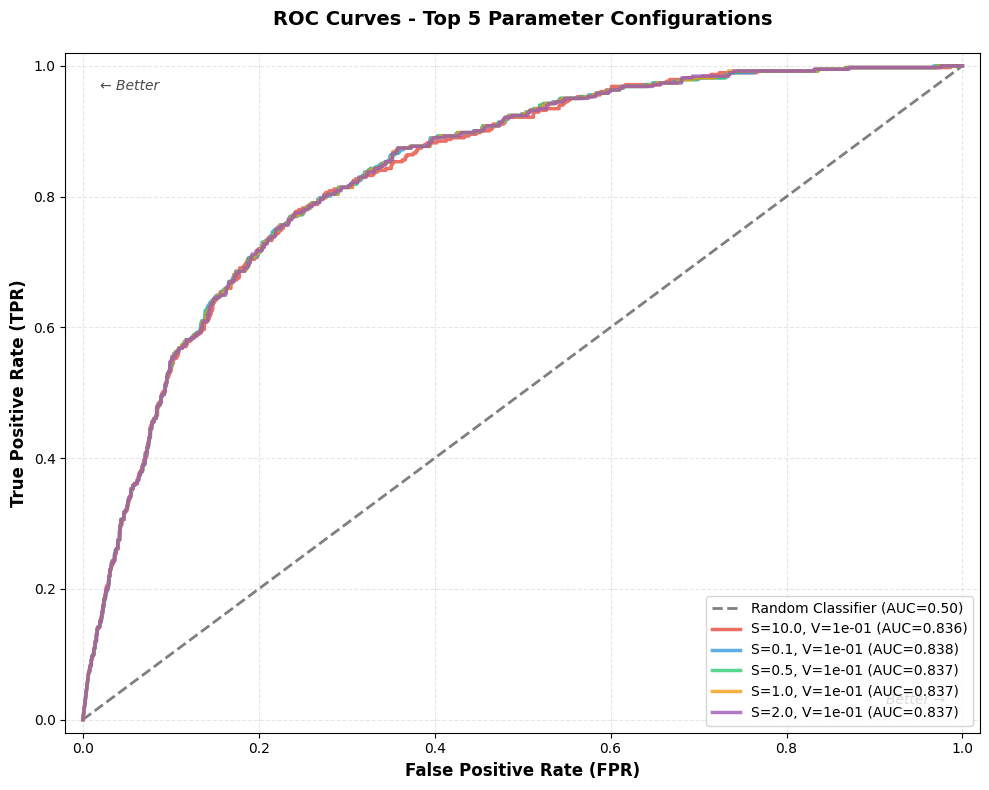


✓ ROC curves plotted for top 5 configurations


In [85]:
# Plot ROC curves for top 5 models
print("="*60)
print("COMPUTING ROC CURVES FOR TOP 5 MODELS")
print("="*60)

# Sort results by accuracy and take top 5
top_5_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)[:5]

plt.figure(figsize=(10, 8))

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.50)', alpha=0.5)

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

print("\nModel Configuration | AUC Score | Accuracy")
print("-" * 60)

for idx, result in enumerate(top_5_results):
    # Compute ROC curve
    fpr, tpr, auc = compute_roc_curve(y_test, result['y_scores'])
    
    # Create label
    label = f"S={result['smoothing']:.1f}, V={result['min_variance']:.0e} (AUC={auc:.3f})"
    
    # Plot
    plt.plot(fpr, tpr, linewidth=2.5, color=colors[idx], label=label, alpha=0.8)
    
    # Print info
    print(f"Rank {idx+1}: Smoothing={result['smoothing']:5.1f}, MinVar={result['min_variance']:.1e} | "
          f"AUC={auc:.4f} | Acc={result['accuracy']:.4f}")

plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Top 5 Parameter Configurations', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

# Add text annotation
plt.text(0.98, 0.02, 'Better →', ha='right', va='bottom', fontsize=10, 
         style='italic', alpha=0.7)
plt.text(0.02, 0.98, '← Better', ha='left', va='top', fontsize=10, 
         style='italic', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n✓ ROC curves plotted for top 5 configurations")

## 17. ROC Curves by Parameter Type

SMOOTHING PARAMETER EFFECT (Variance=1e-6)
Smoothing    AUC        Accuracy
------------------------------------------------------------
0.1          0.8278     0.8143
0.5          0.8277     0.8143
1.0          0.8276     0.8139
2.0          0.8275     0.8143
5.0          0.8272     0.8148
10.0         0.8270     0.8143

VARIANCE THRESHOLD EFFECT (Smoothing=1.0)
MinVariance  AUC        Accuracy
------------------------------------------------------------
1.0e-09      0.8276     0.8139
1.0e-06      0.8276     0.8139
1.0e-03      0.8326     0.8452
1.0e-01      0.8373     0.8468


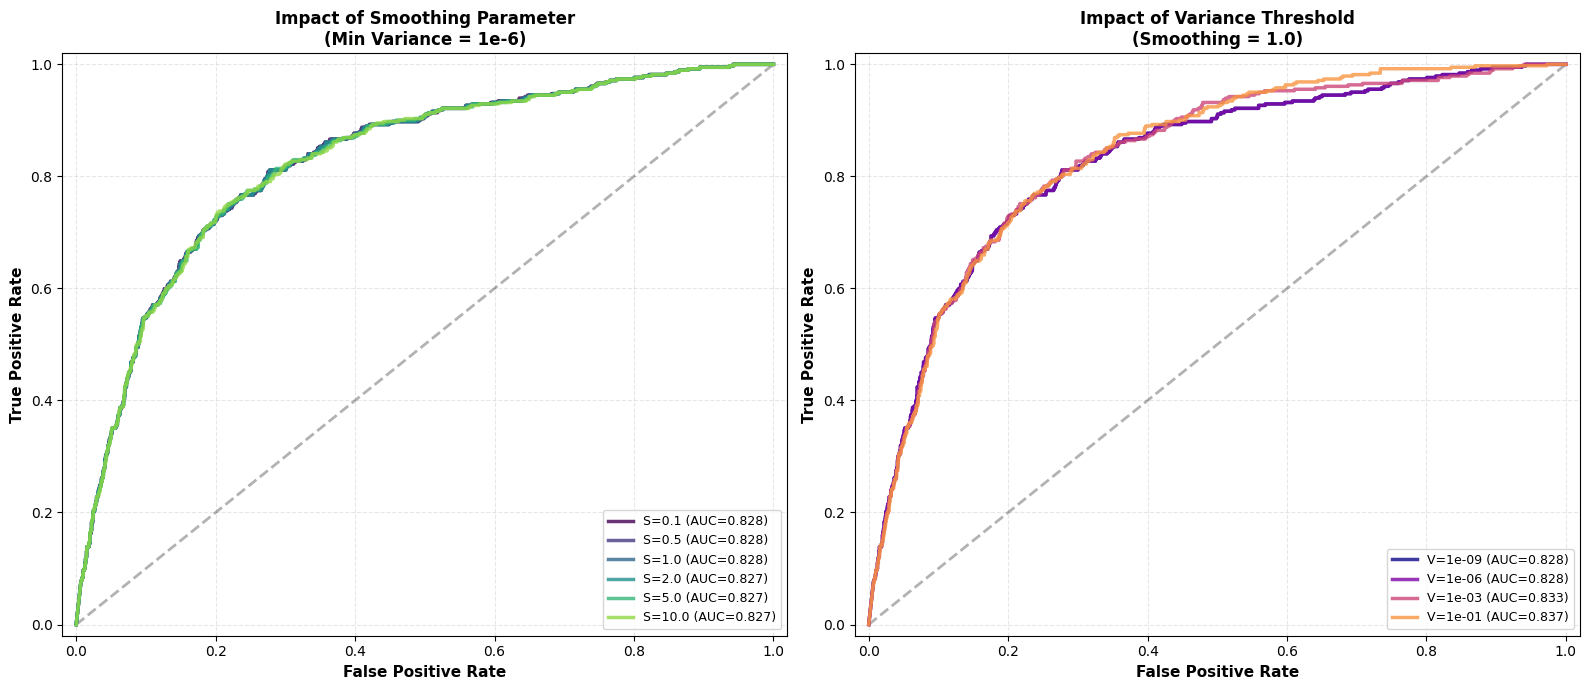


✓ Parameter impact ROC curves plotted


In [86]:
# Create side-by-side ROC plots for parameter analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# LEFT PLOT: Effect of Smoothing Parameter (fix variance at 1e-6)
ax1 = axes[0]
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.3)

fixed_variance = 1e-6
smoothing_colors = plt.cm.viridis([i / len(smoothing_values) for i in range(len(smoothing_values))])

print("="*60)
print("SMOOTHING PARAMETER EFFECT (Variance=1e-6)")
print("="*60)
print(f"{'Smoothing':<12} {'AUC':<10} {'Accuracy'}")
print("-"*60)

for idx, smooth in enumerate(smoothing_values):
    # Find result with this smoothing and fixed variance
    result = [r for r in results if r['smoothing'] == smooth and r['min_variance'] == fixed_variance][0]
    
    # Compute ROC
    fpr, tpr, auc = compute_roc_curve(y_test, result['y_scores'])
    
    # Plot
    ax1.plot(fpr, tpr, linewidth=2.5, color=smoothing_colors[idx], 
             label=f'S={smooth} (AUC={auc:.3f})', alpha=0.8)
    
    print(f"{smooth:<12.1f} {auc:<10.4f} {result['accuracy']:.4f}")

ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax1.set_title('Impact of Smoothing Parameter\n(Min Variance = 1e-6)', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])

# RIGHT PLOT: Effect of Variance Threshold (fix smoothing at 1.0)
ax2 = axes[1]
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.3)

fixed_smoothing = 1.0
variance_colors = plt.cm.plasma([i / len(variance_values) for i in range(len(variance_values))])

print("\n" + "="*60)
print("VARIANCE THRESHOLD EFFECT (Smoothing=1.0)")
print("="*60)
print(f"{'MinVariance':<12} {'AUC':<10} {'Accuracy'}")
print("-"*60)

for idx, var_th in enumerate(variance_values):
    # Find result with this variance and fixed smoothing
    result = [r for r in results if r['min_variance'] == var_th and r['smoothing'] == fixed_smoothing][0]
    
    # Compute ROC
    fpr, tpr, auc = compute_roc_curve(y_test, result['y_scores'])
    
    # Plot
    ax2.plot(fpr, tpr, linewidth=2.5, color=variance_colors[idx], 
             label=f'V={var_th:.0e} (AUC={auc:.3f})', alpha=0.8)
    
    print(f"{var_th:<12.1e} {auc:<10.4f} {result['accuracy']:.4f}")

ax2.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax2.set_title('Impact of Variance Threshold\n(Smoothing = 1.0)', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim([-0.02, 1.02])
ax2.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.show()

print("\n✓ Parameter impact ROC curves plotted")

## 18. Complete ROC Grid - All Configurations

ALL 24 CONFIGURATION ROC CURVES

Grid Layout: Rows=Variance Threshold, Columns=Smoothing



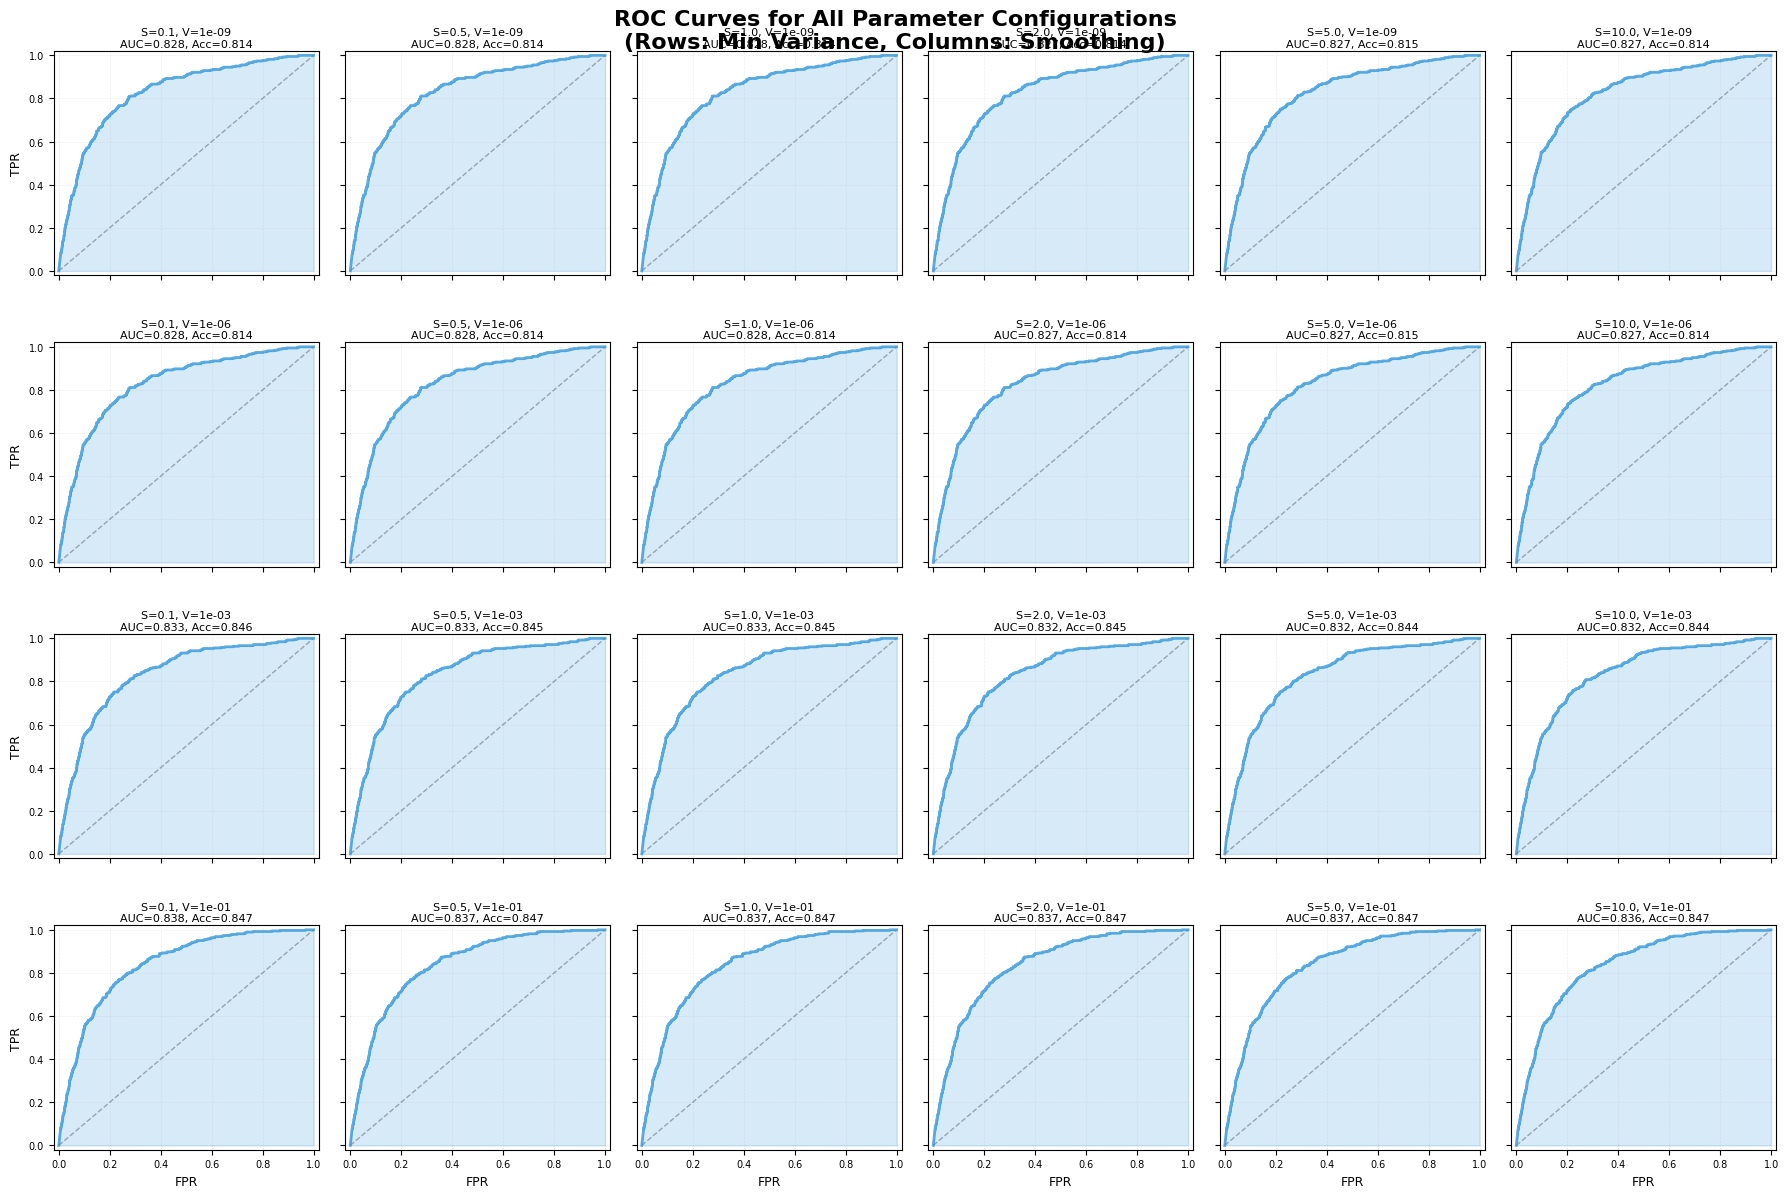

✓ Complete ROC grid plotted

Color coding:
  🟢 Green:  AUC ≥ 0.85 (Excellent)
  🔵 Blue:   0.80 ≤ AUC < 0.85 (Good)
  🔴 Red:    AUC < 0.80 (Needs improvement)


In [87]:
# Create a grid showing all 24 configurations
fig, axes = plt.subplots(len(variance_values), len(smoothing_values), 
                         figsize=(18, 12), sharex=True, sharey=True)

print("="*60)
print("ALL 24 CONFIGURATION ROC CURVES")
print("="*60)
print("\nGrid Layout: Rows=Variance Threshold, Columns=Smoothing")
print()

# Add a main title
fig.suptitle('ROC Curves for All Parameter Configurations\n(Rows: Min Variance, Columns: Smoothing)', 
             fontsize=16, fontweight='bold', y=0.995)

for row_idx, var_th in enumerate(variance_values):
    for col_idx, smooth in enumerate(smoothing_values):
        ax = axes[row_idx, col_idx]
        
        # Find result
        result = [r for r in results if r['smoothing'] == smooth and r['min_variance'] == var_th][0]
        
        # Compute ROC
        fpr, tpr, auc = compute_roc_curve(y_test, result['y_scores'])
        
        # Plot diagonal
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)
        
        # Plot ROC curve
        # Color based on AUC score
        if auc >= 0.85:
            color = '#2ecc71'  # Green for high AUC
        elif auc >= 0.80:
            color = '#3498db'  # Blue for medium AUC
        else:
            color = '#e74c3c'  # Red for low AUC
        
        ax.plot(fpr, tpr, linewidth=2, color=color, alpha=0.8)
        ax.fill_between(fpr, tpr, alpha=0.2, color=color)
        
        # Add title with parameters and AUC
        title = f'S={smooth:.1f}, V={var_th:.0e}\nAUC={auc:.3f}, Acc={result["accuracy"]:.3f}'
        ax.set_title(title, fontsize=8, pad=3)
        
        # Grid
        ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
        
        # Labels only on edges
        if row_idx == len(variance_values) - 1:
            ax.set_xlabel('FPR', fontsize=9)
        if col_idx == 0:
            ax.set_ylabel('TPR', fontsize=9)
        
        # Set limits
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        
        # Tick settings
        ax.tick_params(labelsize=7)

plt.tight_layout()
plt.subplots_adjust(top=0.96, hspace=0.3, wspace=0.1)
plt.show()

print("✓ Complete ROC grid plotted")
print("\nColor coding:")
print("  🟢 Green:  AUC ≥ 0.85 (Excellent)")
print("  🔵 Blue:   0.80 ≤ AUC < 0.85 (Good)")
print("  🔴 Red:    AUC < 0.80 (Needs improvement)")

## 19. AUC Score Summary Table

In [88]:
# Create AUC score table
print("="*80)
print("AUC SCORE MATRIX")
print("="*80)
print("\nRows: Min Variance Threshold | Columns: Smoothing Parameter")
print()

# Compute all AUC scores
auc_matrix = []
for var_th in variance_values:
    row = []
    for smooth in smoothing_values:
        result = [r for r in results if r['smoothing'] == smooth and r['min_variance'] == var_th][0]
        fpr, tpr, auc = compute_roc_curve(y_test, result['y_scores'])
        row.append(auc)
    auc_matrix.append(row)

# Print header
header = "MinVar \\ Smooth |"
for smooth in smoothing_values:
    header += f" {smooth:6.1f} |"
print(header)
print("-" * 80)

# Print rows
for var_idx, var_th in enumerate(variance_values):
    row_str = f"  {var_th:.1e}       |"
    for smooth_idx in range(len(smoothing_values)):
        auc_val = auc_matrix[var_idx][smooth_idx]
        # Add color indicator
        if auc_val >= 0.85:
            marker = "⭐"
        elif auc_val >= 0.80:
            marker = " •"
        else:
            marker = "  "
        row_str += f" {auc_val:.4f}{marker}|"
    print(row_str)

print("\n" + "="*80)
print("LEGEND")
print("="*80)
print("⭐ : AUC ≥ 0.85 (Excellent)")
print("• : 0.80 ≤ AUC < 0.85 (Good)")
print("  : AUC < 0.80 (Needs improvement)")

# Find best AUC
best_auc = max(max(row) for row in auc_matrix)
best_indices = [(i, j) for i, row in enumerate(auc_matrix) for j, val in enumerate(row) if val == best_auc]
best_var_idx, best_smooth_idx = best_indices[0]

print(f"\n🏆 BEST AUC SCORE: {best_auc:.4f}")
print(f"   Parameters: Smoothing={smoothing_values[best_smooth_idx]}, MinVar={variance_values[best_var_idx]:.1e}")

AUC SCORE MATRIX

Rows: Min Variance Threshold | Columns: Smoothing Parameter

MinVar \ Smooth |    0.1 |    0.5 |    1.0 |    2.0 |    5.0 |   10.0 |
--------------------------------------------------------------------------------
  1.0e-09       | 0.8278 •| 0.8277 •| 0.8276 •| 0.8275 •| 0.8272 •| 0.8270 •|
  1.0e-06       | 0.8278 •| 0.8277 •| 0.8276 •| 0.8275 •| 0.8272 •| 0.8270 •|
  1.0e-03       | 0.8330 •| 0.8327 •| 0.8326 •| 0.8325 •| 0.8322 •| 0.8316 •|
  1.0e-01       | 0.8376 •| 0.8374 •| 0.8373 •| 0.8371 •| 0.8367 •| 0.8360 •|

LEGEND
⭐ : AUC ≥ 0.85 (Excellent)
• : 0.80 ≤ AUC < 0.85 (Good)
  : AUC < 0.80 (Needs improvement)

🏆 BEST AUC SCORE: 0.8376
   Parameters: Smoothing=0.1, MinVar=1.0e-01


## Results & Notes- Existing models (logistic regression, NN, tuned RF, tuned XGBoost) achieve ~0.87-0.90 accuracy.- Naive Bayes supplies a lightweight baseline (~0.81 accuracy) despite mixed numerical/categorical features.- Use `python3 naive_bayes_baseline.py` or run the cell above to reproduce the printed comparison table.